In [0]:
%sql
use cat_prod.pega;

In [0]:
%sql
CREATE TABLE Customers (
    customer_id INT PRIMARY KEY,
    first_name VARCHAR(50),
    last_name VARCHAR(50),
    date_of_birth DATE,
    email VARCHAR(100),
    phone VARCHAR(15)
);

CREATE TABLE Agents (
    agent_id INT PRIMARY KEY,
    first_name VARCHAR(50),
    last_name VARCHAR(50),
    email VARCHAR(100),
    phone VARCHAR(15)
);

CREATE TABLE Policies (
    policy_id INT PRIMARY KEY,
    policy_type VARCHAR(50),
    coverage_amount DECIMAL(15,2),
    premium DECIMAL(10,2),
    start_date DATE,
    end_date DATE,
    customer_id INT,
    agent_id INT,
    FOREIGN KEY (customer_id) REFERENCES Customers(customer_id),
    FOREIGN KEY (agent_id) REFERENCES Agents(agent_id)
);

CREATE TABLE Claims (
    claim_id INT PRIMARY KEY,
    policy_id INT,
    claim_amount DECIMAL(15,2),
    claim_date DATE,
    status VARCHAR(20),
    FOREIGN KEY (policy_id) REFERENCES Policies(policy_id)
);

CREATE TABLE Payments (
    payment_id INT PRIMARY KEY,
    policy_id INT,
    amount_paid DECIMAL(10,2),
    payment_date DATE,
    FOREIGN KEY (policy_id) REFERENCES Policies(policy_id)
);


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list, struct, col

# Initialize Spark session
spark = SparkSession.builder.appName("SchemaScanner").getOrCreate()

# Define the catalog and schema
catalog_name = "cat_prod"
schema_name = "pega"
exclude_table = "table_relationships"  # Exclude this table

# Fetch only primary and foreign keys from pega schema
keys_df = spark.sql(f"""
    SELECT kcu.table_name, kcu.column_name
    FROM {catalog_name}.information_schema.key_column_usage kcu
    WHERE kcu.table_schema = '{schema_name}'
    AND kcu.table_name != '{exclude_table}'
""").groupBy("table_name").agg(
    collect_list("column_name").alias("ALLKeys")
)

# Fetch foreign key relationships within pega schema
relations_df = spark.sql(f"""
    SELECT kcu.table_name AS referencing_table,
           kcu.column_name AS referencing_column,
           rc.unique_constraint_name AS referenced_table
    FROM {catalog_name}.information_schema.referential_constraints rc
    JOIN {catalog_name}.information_schema.key_column_usage kcu
    ON rc.constraint_name = kcu.constraint_name
    WHERE rc.constraint_schema = '{schema_name}' 
    AND kcu.table_schema = '{schema_name}'
    AND kcu.table_name != '{exclude_table}'
""")

# Aggregate relationships into structured format
relations_agg_df = relations_df.groupBy("referencing_table").agg(
    collect_list(struct(
        col("referenced_table").alias("RelatedTable"), 
        col("referencing_column").alias("KeyColumn")
    )).alias("Relations")
)

# Join keys and relationships into a single table
final_df = keys_df.join(
    relations_agg_df, 
    keys_df.table_name == relations_agg_df.referencing_table, 
    "left"
).select(
    col("table_name").alias("TableName"),
    col("ALLKeys"),
    col("Relations")
)

# Display results
final_df.show(truncate=False)

# Save the table in Unity Catalog
final_df.write.mode("overwrite").saveAsTable(f"{catalog_name}.{schema_name}.table_relationships")


+---------+----------------------------------+----------------------------------------------------+
|TableName|ALLKeys                           |Relations                                           |
+---------+----------------------------------+----------------------------------------------------+
|claims   |[claim_id, policy_id]             |[{policies_pk, policy_id}]                          |
|policies |[customer_id, agent_id, policy_id]|[{customers_pk, customer_id}, {agents_pk, agent_id}]|
|agents   |[agent_id]                        |NULL                                                |
|payments |[payment_id, policy_id]           |[{policies_pk, policy_id}]                          |
|customers|[customer_id]                     |NULL                                                |
+---------+----------------------------------+----------------------------------------------------+



In [0]:
table = spark.table(f"cat_prod.pega.table_relationships")
display(table)

TableName,ALLKeys,Relations
claims,"List(claim_id, policy_id)","List(List(policies_pk, policy_id))"
policies,"List(customer_id, agent_id, policy_id)","List(List(customers_pk, customer_id), List(agents_pk, agent_id))"
agents,List(agent_id),null
payments,"List(payment_id, policy_id)","List(List(policies_pk, policy_id))"
customers,List(customer_id),null


Visualization

In [0]:
%pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.7 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


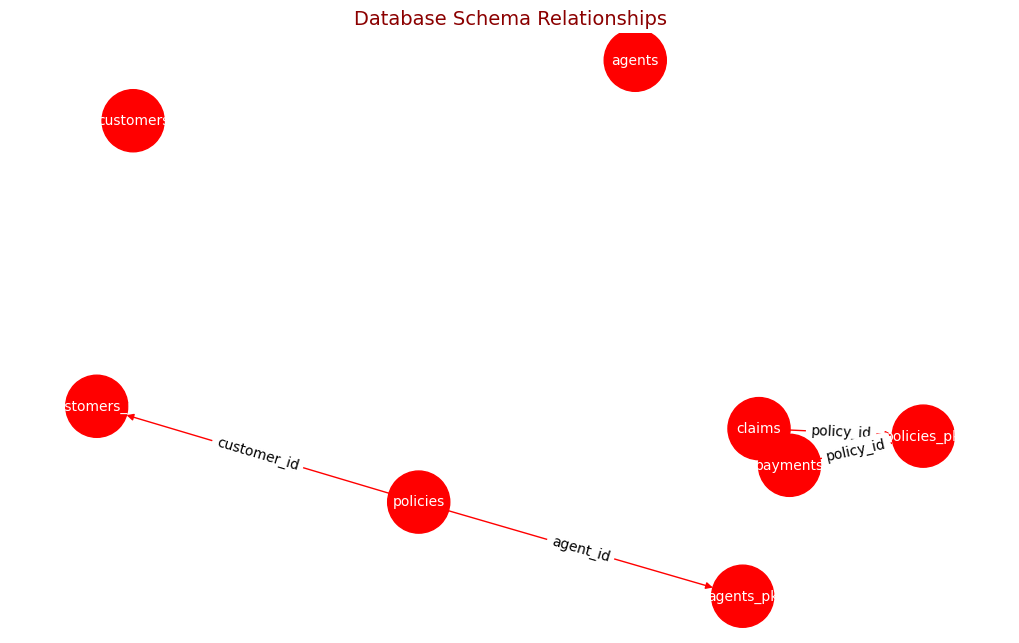

In [0]:
%python
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

tableR = spark.table("cat_prod.pega.table_relationships")
# Convert PySpark DataFrame to Pandas for easier visualization load the table
pandas_df = tableR.toPandas()

# Create a directed graph
G = nx.DiGraph()
# Add nodes (tables)
for table in pandas_df["TableName"]:
    G.add_node(table, color="red")

# Add edges (relationships)
for _, row in pandas_df.iterrows():
    if row["Relations"] is not None:  # Avoid None values
        for relation in row["Relations"]:
            related_table = relation["RelatedTable"]
            key_column = relation["KeyColumn"]
            G.add_edge(row["TableName"], related_table, label=key_column)

# Set up visualization properties
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)  # Layout algorithm for better positioning

# Draw nodes
node_colors = [G.nodes[n].get("color", "red") for n in G.nodes]
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="red", node_size=2000, font_size=10, font_color="white")

# Draw edge labels
edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="black")

# Show the graph
plt.title("Database Schema Relationships", fontsize=14, color="darkred")
plt.show()

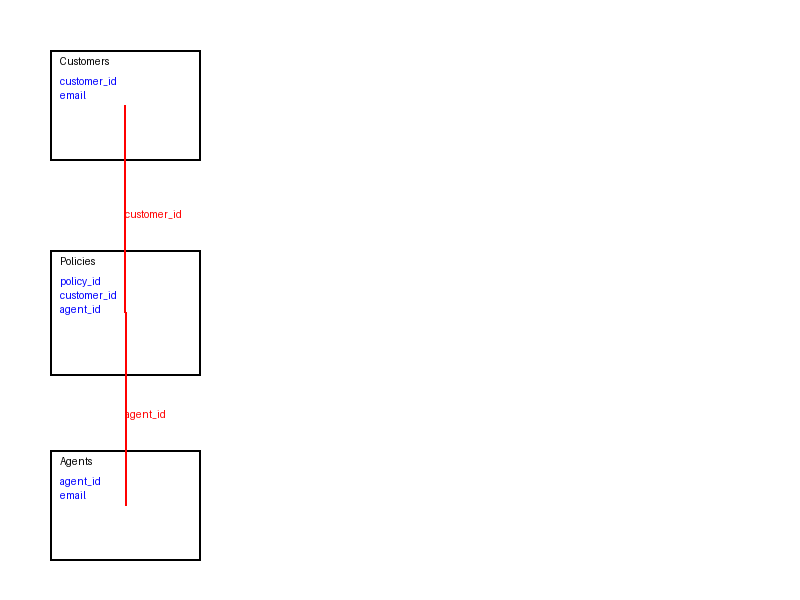

In [0]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import pandas as pd

# Sample data (replace with your DataFrame)
data = [
    {"TableName": "Customers", "ALLKeys": ["customer_id", "email"], "Relations": None},
    {"TableName": "Policies", "ALLKeys": ["policy_id", "customer_id", "agent_id"], "Relations": [
        {"RelatedTable": "Customers", "KeyColumn": "customer_id"},
        {"RelatedTable": "Agents", "KeyColumn": "agent_id"}
    ]},
    {"TableName": "Agents", "ALLKeys": ["agent_id", "email"], "Relations": None}
]

df = pd.DataFrame(data)

# Image settings
img_width, img_height = 800, 600
image = Image.new("RGB", (img_width, img_height), "white")
draw = ImageDraw.Draw(image)

# Font settings (use default system font)
try:
    font = ImageFont.truetype("arial.ttf", 14)
except:
    font = ImageFont.load_default()

# Positioning tables
positions = {}
x, y = 50, 50
spacing = 200

for index, row in df.iterrows():
    table_name = row["TableName"]
    keys = "\n".join(row["ALLKeys"])
    
    # Draw rectangle (table)
    table_width, table_height = 150, 80 + (len(row["ALLKeys"]) * 15)
    draw.rectangle([x, y, x + table_width, y + table_height], outline="black", width=2)
    draw.text((x + 10, y + 5), table_name, fill="black", font=font)
    draw.text((x + 10, y + 25), keys, fill="blue", font=font)
    
    positions[table_name] = (x + table_width // 2, y + table_height // 2)
    y += spacing

# Draw relationships
for index, row in df.iterrows():
    if row["Relations"]:
        for relation in row["Relations"]:
            start_pos = positions[row["TableName"]]
            end_pos = positions.get(relation["RelatedTable"], start_pos)
            draw.line([start_pos, end_pos], fill="red", width=2)
            draw.text(((start_pos[0] + end_pos[0]) // 2, (start_pos[1] + end_pos[1]) // 2), relation["KeyColumn"], fill="red", font=font)

# Show image
image.show()

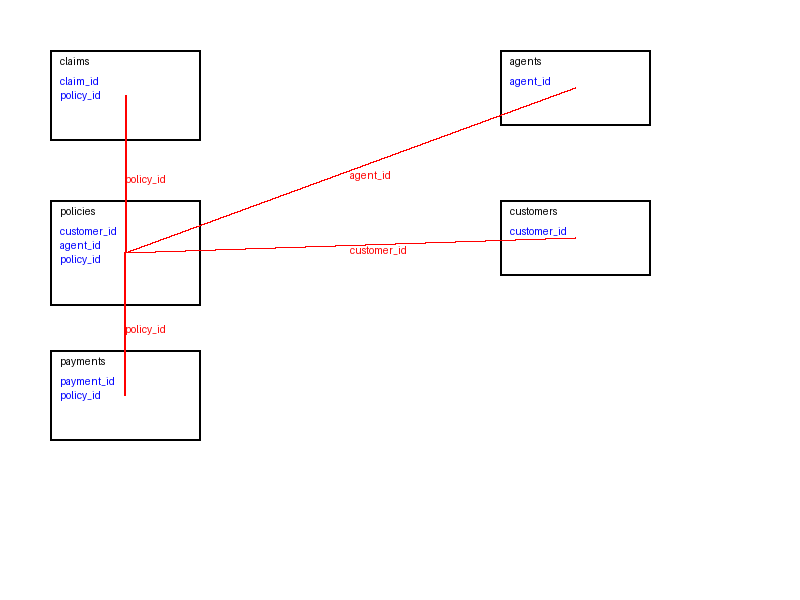

In [0]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import pandas as pd

# Sample data (replace with your DataFrame)
data = [
    {"TableName": "claims", "ALLKeys": ["claim_id", "policy_id"], "Relations": [
        {"RelatedTable": "policies", "KeyColumn": "policy_id"}
    ]},
    {"TableName": "policies", "ALLKeys": ["customer_id", "agent_id", "policy_id"], "Relations": [
        {"RelatedTable": "customers", "KeyColumn": "customer_id"},
        {"RelatedTable": "agents", "KeyColumn": "agent_id"}
    ]},
    {"TableName": "agents", "ALLKeys": ["agent_id"], "Relations": None},
    {"TableName": "payments", "ALLKeys": ["payment_id", "policy_id"], "Relations": [
        {"RelatedTable": "policies", "KeyColumn": "policy_id"}
    ]},
    {"TableName": "customers", "ALLKeys": ["customer_id"], "Relations": None}
]

df = pd.DataFrame(data)

# Image settings
img_width, img_height = 800, 600
image = Image.new("RGB", (img_width, img_height), "white")
draw = ImageDraw.Draw(image)

# Font settings (use default system font)
try:
    font = ImageFont.truetype("arial.ttf", 14)
except:
    font = ImageFont.load_default()

# Positioning tables
positions = {}
x, y = 50, 50
spacing = 150
disconnected_x, disconnected_y = 500, 50  # Position for disconnected tables

def is_connected(relations):
    return relations is not None and len(relations) > 0

# Place tables on the canvas
for index, row in df.iterrows():
    table_name = row["TableName"]
    keys = "\n".join(row["ALLKeys"])
    
    # Determine position
    if is_connected(row["Relations"]):
        table_x, table_y = x, y
        y += spacing
    else:
        table_x, table_y = disconnected_x, disconnected_y
        disconnected_y += spacing
    
    # Draw rectangle (table)
    table_width, table_height = 150, 60 + (len(row["ALLKeys"]) * 15)
    draw.rectangle([table_x, table_y, table_x + table_width, table_y + table_height], outline="black", width=2)
    draw.text((table_x + 10, table_y + 5), table_name, fill="black", font=font)
    draw.text((table_x + 10, table_y + 25), keys, fill="blue", font=font)
    
    positions[table_name] = (table_x + table_width // 2, table_y + table_height // 2)

# Draw relationships
for index, row in df.iterrows():
    if is_connected(row["Relations"]):
        for relation in row["Relations"]:
            start_pos = positions[row["TableName"]]
            end_pos = positions.get(relation["RelatedTable"], start_pos)
            draw.line([start_pos, end_pos], fill="red", width=2)
            draw.text(((start_pos[0] + end_pos[0]) // 2, (start_pos[1] + end_pos[1]) // 2), relation["KeyColumn"], fill="red", font=font)

# Show image
image.show()


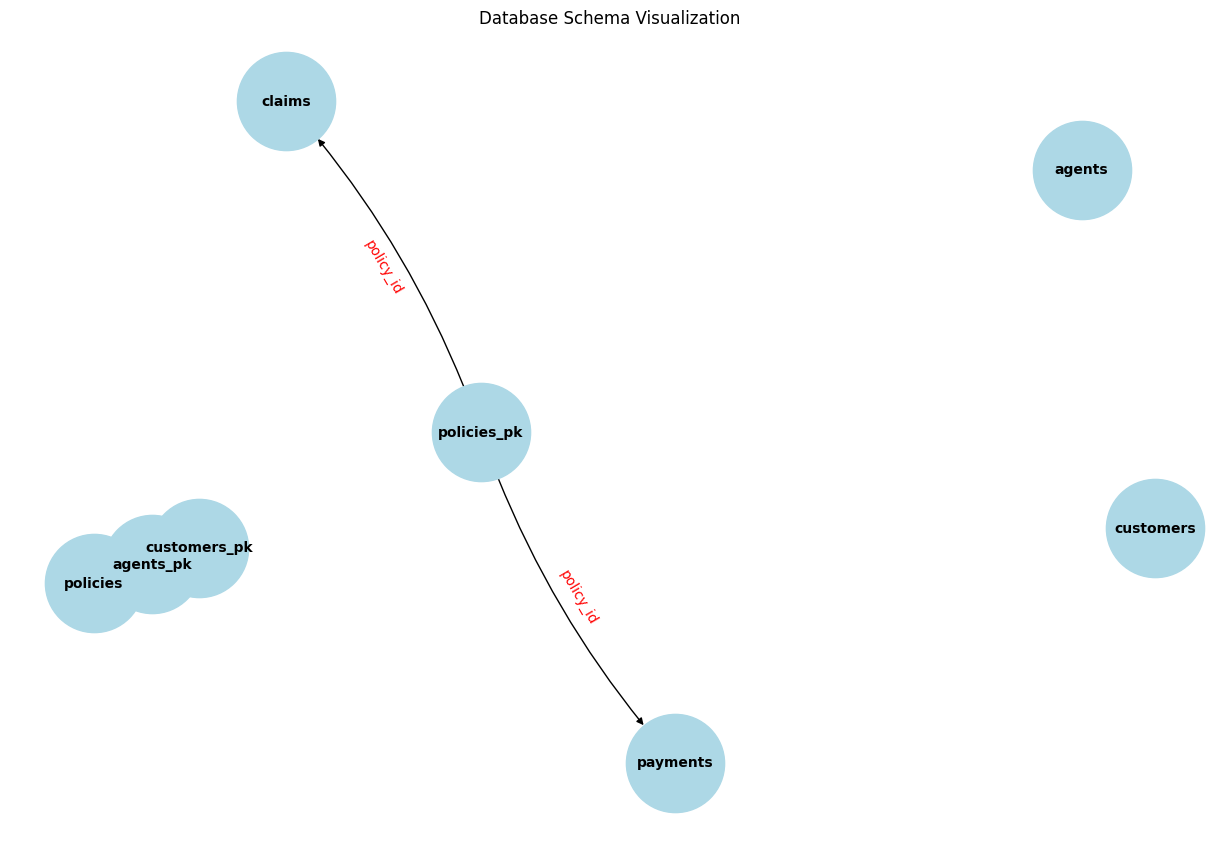

In [0]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import networkx as nx

# Sample data (replace with your DataFrame)
data = spark.table("cat_prod.pega.table_relationships").toPandas()

df = pd.DataFrame(data)

# Create a directed graph
G = nx.DiGraph()
positions = {}

def is_connected(relations):
    return relations is not None and len(relations) > 0

# Define node positions
x, y = 0, 0
spacing = 2
disconnected_x, disconnected_y = 5, 0

table_styles = {}
for index, row in df.iterrows():
    table_name = row["TableName"]
    keys = "\n".join(row["ALLKeys"])
    
    # Determine position
    if is_connected(row["Relations"]):
        positions[table_name] = (x, y)
        y -= spacing
    else:
        positions[table_name] = (disconnected_x, disconnected_y)
        disconnected_y -= spacing
    
    # Add table to graph
    G.add_node(table_name, label=f"{table_name}\n{keys}")
    table_styles[table_name] = {"fillcolor": "lightblue", "shape": "record", "style": "filled"}

# Define edges with bi-directional arrows
for index, row in df.iterrows():
    if is_connected(row["Relations"]):
        for relation in row["Relations"]:
            G.add_edge(relation["RelatedTable"], row["TableName"], label=relation["KeyColumn"])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1, seed=42, scale=5, pos=positions)
nx.draw(G, pos, with_labels=True, node_size=5000, node_color="lightblue", edge_color="black", font_size=10, font_weight="bold", connectionstyle="arc3,rad=0.1")
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d["label"] for u, v, d in G.edges(data=True)}, font_color="red")
plt.title("Database Schema Visualization")
plt.show()